
<h1><center><font size=10>Hotel Booking Cancellation Prediction</center></font></h1>

### What to expect in this notebook

*  Introduction
*  Objectives
*  Essential Libraries
*  Exploratory Data Analysis
*  Data Preprocessing
*  Train Test Split
*  Decision Tree Classifier
*  Random Forest Classifier
*  Naive Bayes Classifier
*  XGBOOST and ADABOOST classifier
*  Model tuning using GridSearch
*  Model Evaluation
*  Model deployment

# **Introduction**

A chain of hotels, INN Hotels Group, is facing a problem of inventory loss due to booking cancellations, resulting in revenue loss. They want to build Data Science solution that will help them predict the likelihood of a booking getting cancelled so that they can take measures to fill in potential vacancies.

## **Objectives**
-----------------
To implement a data science-based solution to predict the probability of booking cancellations.

In [3]:
# Mounting the drive in google colab (should be commented out when working on a local machine)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the necessary libraries

In [1]:
# installing the library for deploying ML models
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size

In [4]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# removing the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# setting the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 2 decimal points
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# library to split data
from sklearn.model_selection import train_test_split

# library to build ML model
from sklearn.tree import DecisionTreeClassifier

# library to tune ML model
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# libraries to evaluate the ML model
from sklearn.metrics import f1_score, make_scorer

#Machine Learing Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

# libraries to deploy the ML model
import os
import joblib
import gradio as gr

## Loading the dataset

In [5]:
# # importing using Google Colab
# # loading the data into a Pandas dataframe
hotel = pd.read_csv('/content/drive/MyDrive/Copilot/INNHotelsGroup.csv')

In [6]:
# # importing using Jupyter Notebook

# # loading the data into a Pandas dataframe
#hotel = pd.read_csv("INNHotelsGroup.csv")

In [7]:
# showing 10 rows od data at random selection
hotel.sample(10, random_state=10)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
18212,103,Offline,0,115.00,1,0,2018-04-19,0,2,Canceled
3267,86,Online,2,90.00,2,1,2018-11-04,0,2,Not_Canceled
28472,20,Online,1,92.67,2,1,2018-12-09,0,2,Not_Canceled
34178,22,Online,1,126.04,2,4,2018-12-28,0,10,Not_Canceled
35404,109,Online,4,105.21,2,2,2018-07-06,0,4,Not_Canceled
31551,30,Offline,0,127.15,1,0,2018-10-28,0,1,Not_Canceled
30927,192,Offline,0,100.00,2,0,2018-08-25,0,3,Not_Canceled
30473,278,Online,0,103.95,2,2,2018-07-16,1,1,Canceled
27445,0,Online,0,85.93,1,0,2018-05-12,0,1,Not_Canceled
33154,37,Online,1,92.31,1,4,2018-12-15,0,9,Canceled


In [8]:
# showing the first 5 tows of the dataset
hotel.head(5)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,224,Offline,0,65.00,2,1,2017-10-02,0,2,Not_Canceled
1,5,Online,1,106.68,2,2,2018-11-06,0,3,Not_Canceled
2,1,Online,0,60.00,1,2,2018-02-28,0,1,Canceled
3,211,Online,0,100.00,2,0,2018-05-20,0,2,Canceled
4,48,Online,0,94.50,2,1,2018-04-11,0,1,Canceled


In [9]:
# showing the last 5 rows of the dataset
hotel.tail(5)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
36270,85,Online,1,167.80,3,2,2018-08-03,0,6,Not_Canceled
36271,228,Online,2,90.95,2,1,2018-10-17,0,3,Canceled
36272,148,Online,2,98.39,2,2,2018-07-01,0,6,Not_Canceled
36273,63,Online,0,94.50,2,0,2018-04-21,0,3,Canceled
36274,207,Offline,0,161.67,2,1,2018-12-30,0,2,Not_Canceled


# **Exploratory Data Analysis**


In [10]:
# creating a copy of the data to avoid any changes to original data
data = hotel.copy()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lead_time                   36275 non-null  int64  
 1   market_segment_type         36275 non-null  object 
 2   no_of_special_requests      36275 non-null  int64  
 3   avg_price_per_room          36275 non-null  float64
 4   no_of_adults                36275 non-null  int64  
 5   no_of_weekend_nights        36275 non-null  int64  
 6   arrival_date                36275 non-null  object 
 7   required_car_parking_space  36275 non-null  int64  
 8   no_of_week_nights           36275 non-null  int64  
 9   booking_status              36275 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 2.8+ MB


In [12]:
data.shape

(36275, 10)

## **observations:**

*  There are 36275 number of rows and 10 columns in the dataset
*  The dataset contaons both numerical (as int64 and float64) and categorical (asobject) variables.
*  There are no mising values in the dataset.

## **Checking for missing values**

In [13]:
data.isna().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

## **Checking for unique values**

In [14]:
# unique values in the columns
for i in data.columns:
    print(i, data[i].nunique())

lead_time 352
market_segment_type 2
no_of_special_requests 6
avg_price_per_room 3930
no_of_adults 5
no_of_weekend_nights 8
arrival_date 549
required_car_parking_space 2
no_of_week_nights 18
booking_status 2


## **Checking for duplicates and removing them**

In [15]:
# check for duplicates
duplicates = data.duplicated()
print("Number of duplicate rows = ", duplicates.sum())

Number of duplicate rows =  10421


In [16]:
# dropping duplicated rows
data = data.drop_duplicates()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25854 entries, 0 to 36273
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lead_time                   25854 non-null  int64  
 1   market_segment_type         25854 non-null  object 
 2   no_of_special_requests      25854 non-null  int64  
 3   avg_price_per_room          25854 non-null  float64
 4   no_of_adults                25854 non-null  int64  
 5   no_of_weekend_nights        25854 non-null  int64  
 6   arrival_date                25854 non-null  object 
 7   required_car_parking_space  25854 non-null  int64  
 8   no_of_week_nights           25854 non-null  int64  
 9   booking_status              25854 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 2.2+ MB


## **Observation:**

*  After droping all duplicate rows, we have a total of 25854 number of rows left.

## **Descriptive statistics on the numerical variables**

In [18]:
# checking the statistical summary of the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,25854.00,66.65,68.64,0.00,12.00,44.00,100.00,443.00
no_of_special_requests,25854.00,0.74,0.82,0.00,0.00,1.00,1.00,5.00
avg_price_per_room,25854.00,105.88,37.81,0.00,80.75,100.00,127.00,540.00
no_of_adults,25854.00,1.89,0.53,0.00,2.00,2.00,2.00,4.00
no_of_weekend_nights,25854.00,0.88,0.89,0.00,0.00,1.00,2.00,7.00
required_car_parking_space,25854.00,0.04,0.20,0.00,0.00,0.00,0.00,1.00
no_of_week_nights,25854.00,2.27,1.51,0.00,1.00,2.00,3.00,17.00


## **Observations:**

* The number of adults ranges from 0 to 4, which is usual.
* The range of the number of weeks and weekend nights seems fine. Though 7 weekends might be a very long stay.
* At least 75% of the customers do not require car parking space.
* On average the customers book 67 days in advance. There's also a very huge difference in 75th percentile and maximum value which indicates there might be outliers present in this column.
* The average price per room is about 106 euros. There's a huge difference between the 75th percentile and the maximum value which indicates there might be outliers present in this column.

## **Univariate analysis**

In [19]:
# defining a function to create a bar graph with percentage values

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=15,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    # increase the size of x-axis and y-axis scales
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    # setting axis labels
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=15)
    ax.set_ylabel('')

    # show the plot
    plt.show()

In [20]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(loc="upper left", fontsize=12, bbox_to_anchor=(1, 1))

    # setting the formatting for x-axis
    plt.xticks(fontsize=15, rotation=0)
    plt.xlabel(predictor.replace('_', ' ').title(), fontsize=15)
    # setting the formatting for y-axis
    plt.yticks(fontsize=15)
    # show the plot
    plt.show()

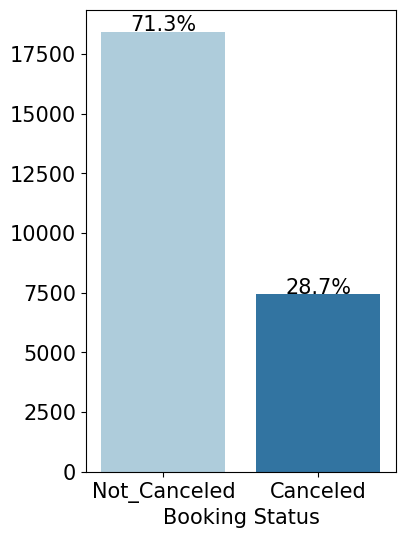

In [21]:
# visualizing the number of cancelled bookings
labeled_barplot(data, "booking_status", perc=True)

- Approx. one-third of the bookings were canceled

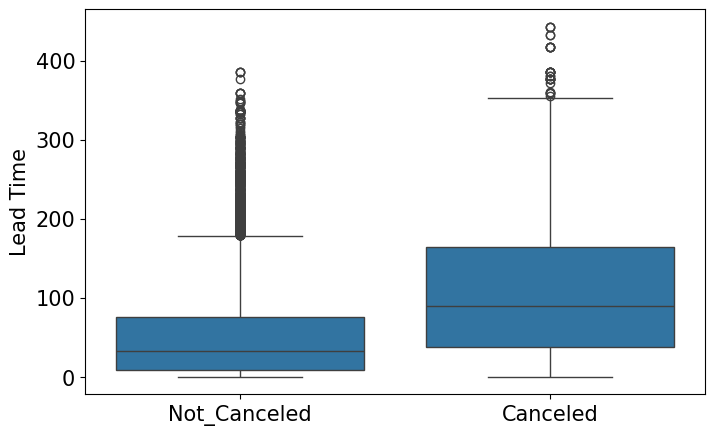

In [22]:
# visualizing the relationship between lead time and booking cancellation
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="booking_status", y="lead_time")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Lead Time', fontsize=15);

- The higher the lead time, higher is the chances of cancellation

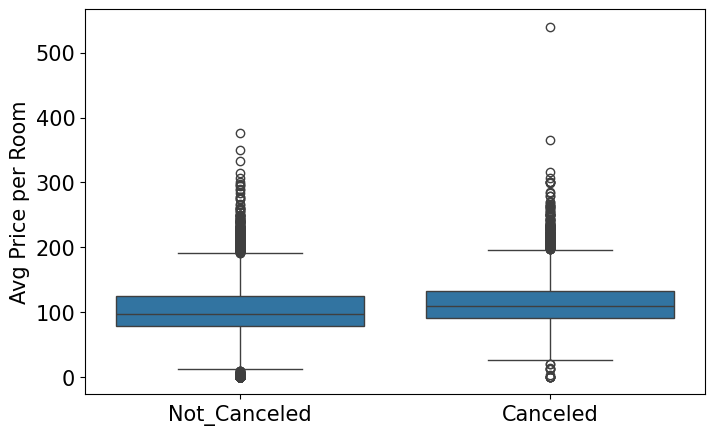

In [24]:
# visualizing the relationship between avg room price and booking cancellation
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="booking_status", y="avg_price_per_room")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Avg Price per Room', fontsize=15);

- The booking status marginally varies with the average price per room

booking_status       Canceled  Not_Canceled    All
market_segment_type                               
Offline                   486          3604   4090
Online                   6942         14822  21764
All                      7428         18426  25854
------------------------------------------------------------------------------------------------------------------------


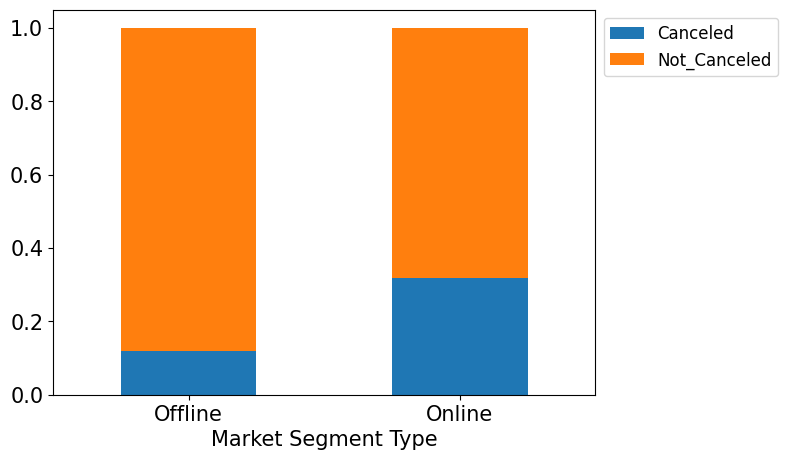

In [25]:
stacked_barplot(data, "market_segment_type", "booking_status")

* Offline bookings have witnessed a slightly lower rate of cancellation compared to online bookings

In [26]:
# converting the 'arrival_date' column to datetime type
data['arrival_date'] = pd.to_datetime(data['arrival_date'])

# extracting month from 'arrival_date'
data['arrival_month'] = data['arrival_date'].dt.month

In [27]:
# grouping the data on arrival months and extracting the count of bookings
monthly_data = data.groupby(["arrival_month"])["booking_status"].count().to_frame().reset_index()
monthly_data.columns = ['Month', 'Bookings']
monthly_data

,Month,Bookings
0,1,764
1,2,1311
2,3,1981
3,4,2025
4,5,1834
5,6,1841
6,7,2279
7,8,3051
8,9,3033
9,10,3186


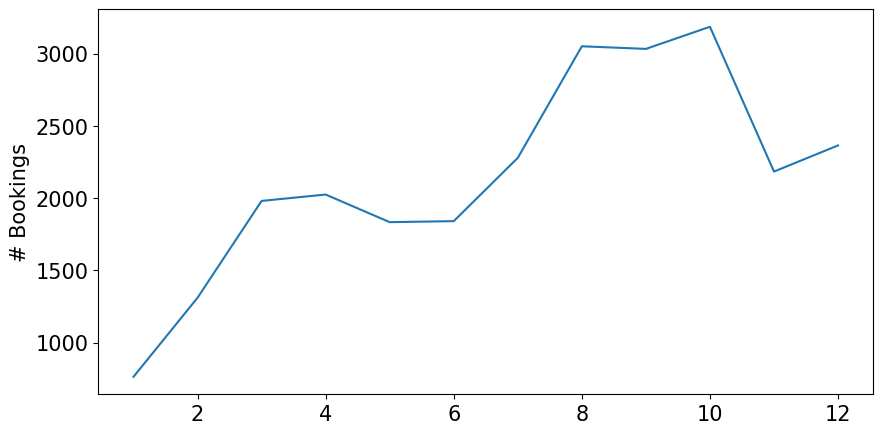

In [28]:
# visualizing the trend of number of bookings across months
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_data, x="Month", y="Bookings")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('# Bookings', fontsize=15);

* The trend shows that the number of bookings rise from January to April, remain consistent from April to July, then rise again till October where it reaches a peak, and then drops down again in November and December

booking_status  Canceled  Not_Canceled    All
arrival_month                                
1                     15           749    764
2                    287          1024   1311
3                    550          1431   1981
4                    635          1390   2025
5                    583          1251   1834
6                    598          1243   1841
7                    914          1365   2279
8                   1210          1841   3051
9                    888          2145   3033
10                   916          2270   3186
11                   494          1690   2184
12                   338          2027   2365
All                 7428         18426  25854
------------------------------------------------------------------------------------------------------------------------


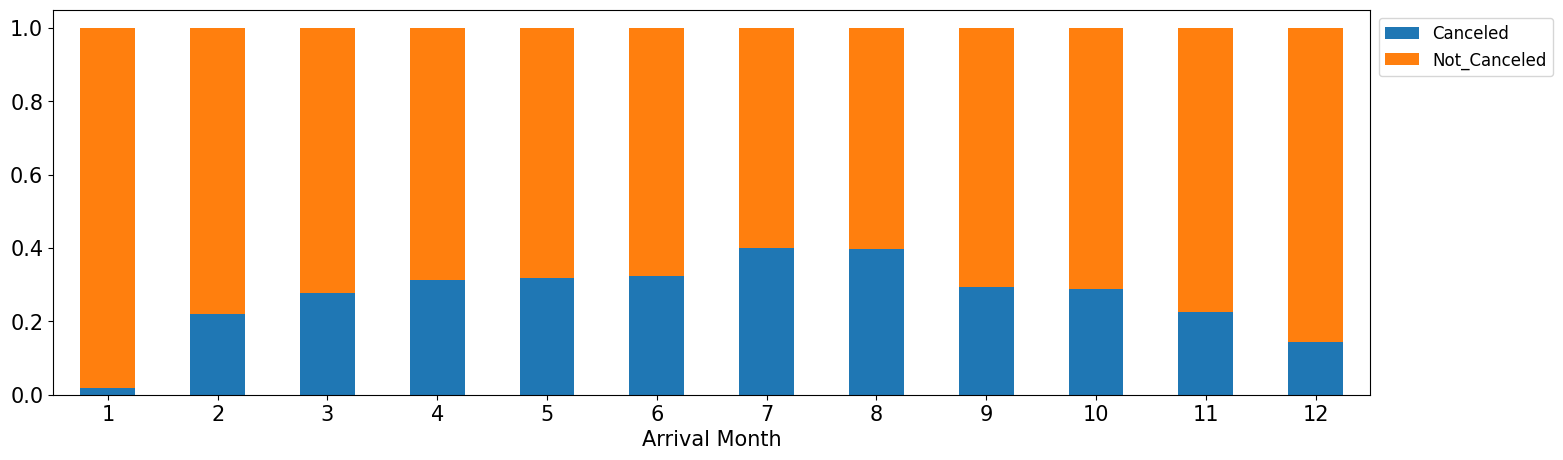

In [31]:
##Let's check the percentage of bookings canceled in each month
stacked_barplot(data, "arrival_month", "booking_status")

* January and December witness a significantly lower rate of cancellation compared to the other months, and July witnesses the highest rate of cancellation

We also noted the following based on the EDA conducted:

- The booking status does not significantly vary with the average price per room.
- The monthly booking trends show that the number of bookings rise from January to April, declines from April to June and rise again till October where it reaches a peak, and then drops down again in November and start to rise in December.

We see that variables like lead time and arrival month have a fair amount of difference for cancelled and non-cancelled bookings, while some of the other variables like market segment and avg price per room do not. But we can only visualize the data in 2 or 3 dimensions, and there may be more complex relationships in the data beyond that which cannot be captured visually.

So, we need an ML model that can do the following:
  - Take the booking detail (customer arrival month, booking lead time, no. of guests, and more) as input
  - Learn the patterns in the input data
  - Fit a mathematical model using these patterns to identify which situations lead to booking cancellation
  - Predict the likelihood of cancellation of a new booking

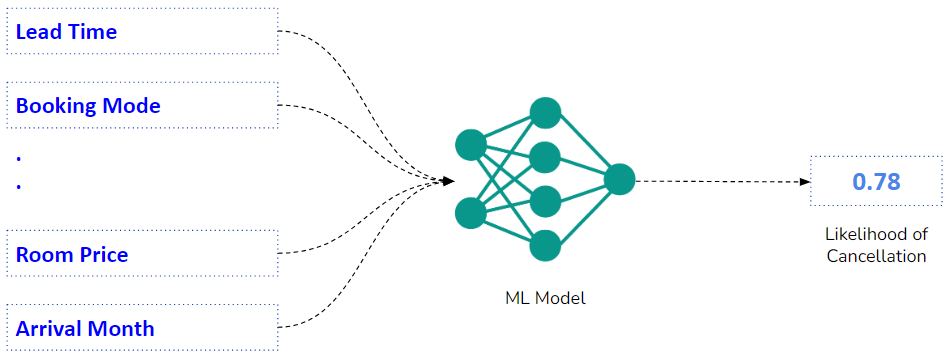

# **Model Building**


## Data Preprocessing

In [32]:
# encoding the output (also called target) attribute
data["booking_status"] = data["booking_status"].apply(
    lambda x: 1 if x == "Canceled" else 0
)

In [33]:
# separating the input and output variables
X = data.drop(["booking_status","arrival_date"], axis=1)
y = data["booking_status"]

# encoding the categorical variables
X = pd.get_dummies(X, drop_first=True)

# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [34]:
X.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_month,market_segment_type_Online
0,224,0,65.00,2,1,0,2,10,0
1,5,1,106.68,2,2,0,3,11,1
2,1,0,60.00,1,2,0,1,2,1
3,211,0,100.00,2,0,0,2,5,1
4,48,0,94.50,2,1,0,1,4,1


## Model Training and Evaluation

## **Decision tree classifier**

In [35]:
# defining the ML model to build
model = DecisionTreeClassifier(random_state=1)

# training the ML model on the train data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [36]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

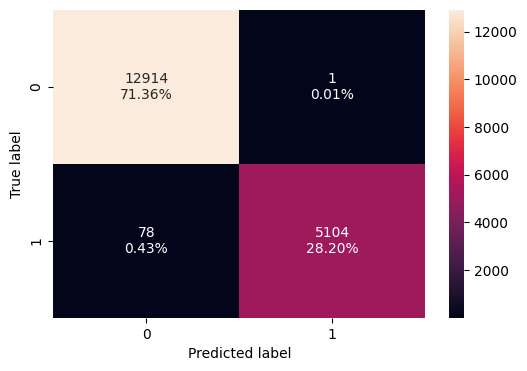

In [37]:
# confusion matrix for train data
confusion_matrix_sklearn(model, X_train, y_train)

In [38]:
# evaluating the model performance on the train data
model_train_predictions = model.predict(X_train)
model_train_score = f1_score(y_train, model_train_predictions)

print("Model Score on Train Data:", np.round(100*model_train_score, 2))

Model Score on Train Data: 99.23


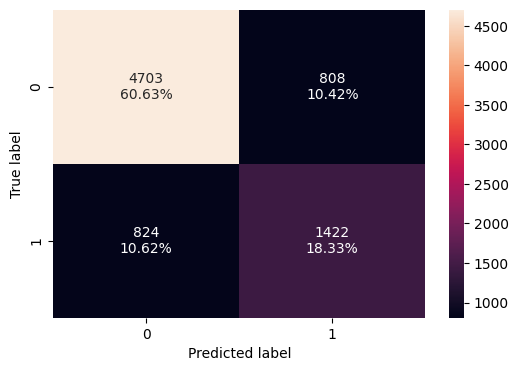

In [ ]:
# confusion matrix for test data
confusion_matrix_sklearn(model, X_test, y_test)

In [39]:
# evaluating the model performance on the test data
model_test_predictions = model.predict(X_test)
model_test_score = f1_score(y_test, model_test_predictions)

print("Model Score on Test Data:", np.round(100*model_test_score, 2))

Model Score on Test Data: 63.54


## Understanding Model Predictions and Business Consequences

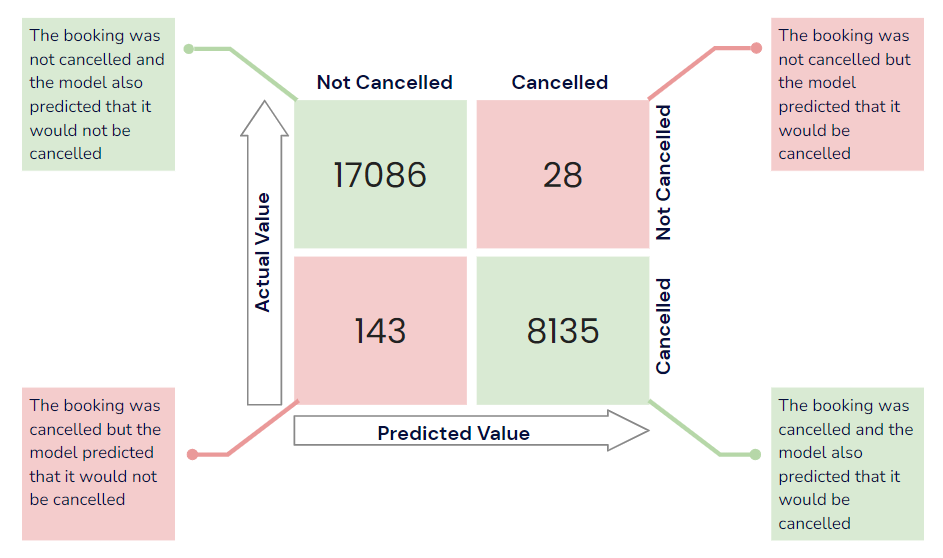

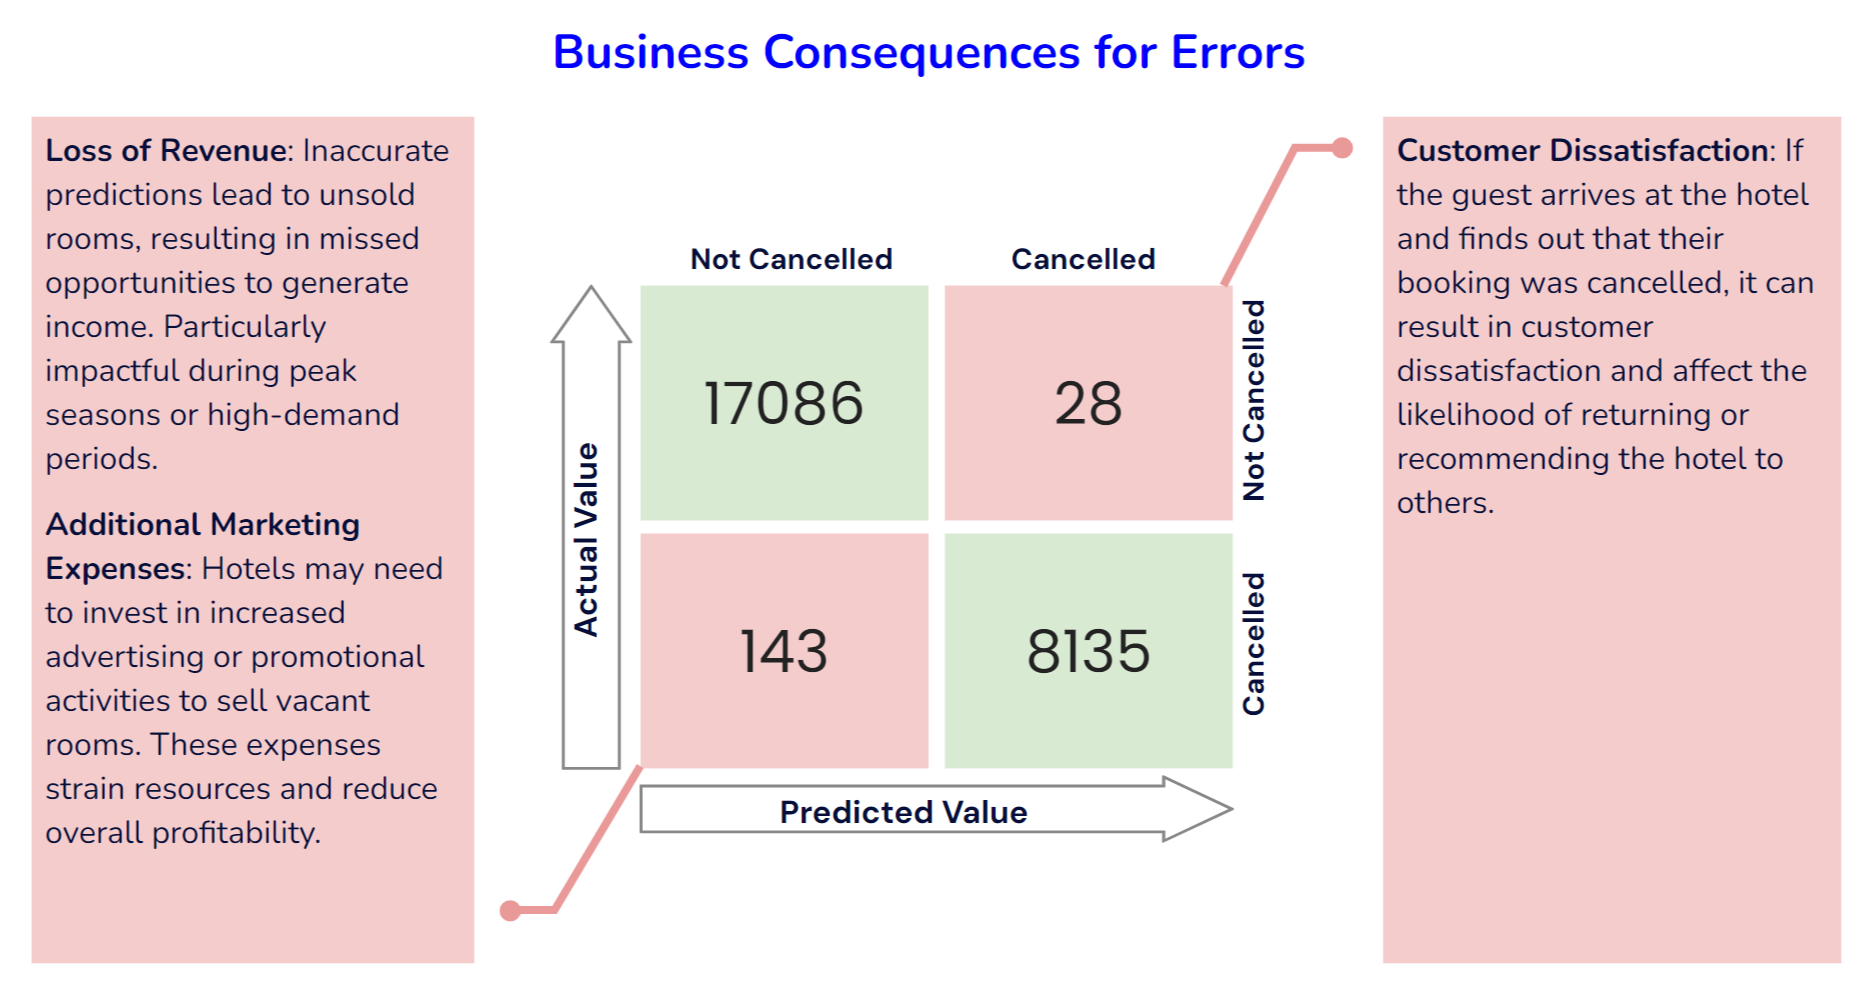

## **Observations from Model Evaluation:**

The ML model has a score of 99% on the train data and 63% on the test data respectively.

- This shows that while the model work really well on the data it is trained on, it fails to replicate the same performance on unseen data.

- This becomes a worry as the ultimate goal would be to make predictions for new reservations that have not come in yet, and we do not want a model that will fail to perform well on such unseen data and that would require model tuning.

## Model Tuning

In [40]:
# choosing the type of ML Model
dummy_model = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# defining the grid of parameters of the ML Model to choose from
parameters = {
    "max_leaf_nodes": [150, 250],
    "min_samples_split": [10, 30],
}

# defining the model score on which we want to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# running the model tuning algorithm
grid_obj = GridSearchCV(dummy_model, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

In [42]:
# selecting the best combination of parameters for the model to create a new model
tuned_model = grid_obj.best_estimator_

# training the new ML Model
tuned_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=150,
                       min_samples_split=10, random_state=1)

In [43]:
# evaluating the model performance on the train data
tuned_model_train_predictions = tuned_model.predict(X_train)
tuned_model_train_score = f1_score(y_train, tuned_model_train_predictions)

print("Model Score on Train Data:", np.round(100*tuned_model_train_score, 2))

Model Score on Train Data: 75.17


In [44]:
# evaluating the model performance on the test data
tuned_model_test_predictions = tuned_model.predict(X_test)
tuned_model_test_score = f1_score(y_test, tuned_model_test_predictions)

print("Model Score on Test Data:", np.round(100*tuned_model_test_score, 2))

Model Score on Test Data: 70.45


- The train and test performances are much more similar now, so we can say that the model is able to generalize well

## Model Testing

In [45]:
final_model = tuned_model

In [46]:
# evaluating the model performance on the test data
final_model_test_predictions = final_model.predict(X_test)
final_model_test_score = f1_score(y_test, final_model_test_predictions)

print("Model Score on Test Data:", np.round(100*final_model_test_score, 2))

Model Score on Test Data: 70.45


## Observations from Model Testing

- The ML model has a score of ~70% on the test data, which is a good score.
- We can now move ahead to the next stage.

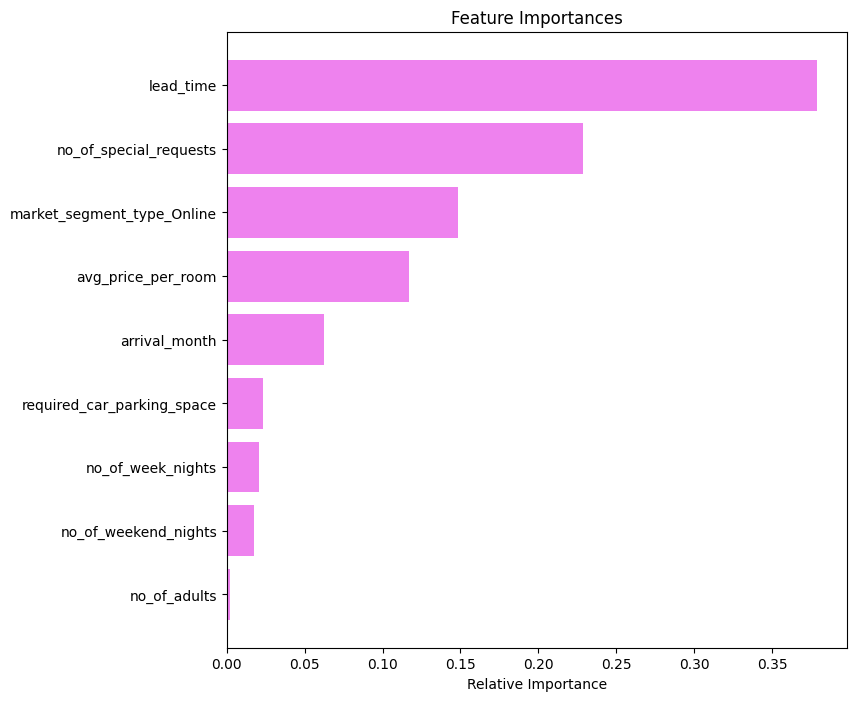

In [47]:
importances = tuned_model.feature_importances_

indices = np.argsort(importances)

feature_names = list(X_train.columns)

plt.figure(figsize = (8, 8))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

## **Observations:**

- **Lead Time**, **numner of sepcial request, market segement type online, average price per room,** and **arrival month** are the most important features.
- The rest of the variables have very little or no impact in this model, while deciding whether a customer will cancel or not.

## **Random Forest Classifier**

In [48]:
# Fitting the Random Forest classifier on the training data

# Initialize the Random Forest classifier with class_weight='balanced'
rf_estimator = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [49]:
# evaluating the model performance on the train data
model_train_predictions_rf = rf_estimator.predict(X_train)
model_train_score_rf = f1_score(y_train, model_train_predictions_rf)

print("Model Score on Train Data:", np.round(100*model_train_score_rf, 2))

Model Score on Train Data: 99.24


In [50]:
# evaluating the model performance on the test data
final_model_test_predictions_rf = rf_estimator.predict(X_test)
final_model_test_score_rf = f1_score(y_test, final_model_test_predictions_rf)

print("Model Score on Test Data:", np.round(100*final_model_test_score_rf, 2))

Model Score on Test Data: 70.05


## **Model tuning, Random Forest**

In [51]:
from sklearn import metrics
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [110, 120],
    "max_depth": [6, 7],
    "min_samples_leaf": [20, 25],
    "max_features": [0.8, 0.9],
    "max_samples": [0.9, 1],
    "class_weight": ["balanced",{0: 0.3, 1: 0.7}]
             }
# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features=0.8, max_samples=0.9,
                       min_samples_leaf=20, n_estimators=120, random_state=7)

In [52]:
# evaluating the model performance on the train data
tuned_model_train_predictions_rf = rf_estimator_tuned.predict(X_train)
tuned_model_train_score_rf = f1_score(y_train, tuned_model_train_predictions_rf)

print("Model Score on Train Data:", np.round(100*tuned_model_train_score_rf, 2))

Model Score on Train Data: 72.54


In [53]:
# evaluating the model performance on the test data
tuned_model_test_predictions_rf = rf_estimator_tuned.predict(X_test)
tuned_model_test_score_rf = f1_score(y_test, tuned_model_test_predictions_rf)

print("Model Score on Train Data:", np.round(100*tuned_model_test_score, 2))

Model Score on Train Data: 70.45


## **Observations:**

*  The model performance after tuning is 72% on the train data and 70.5 on the test data indicating a good model.

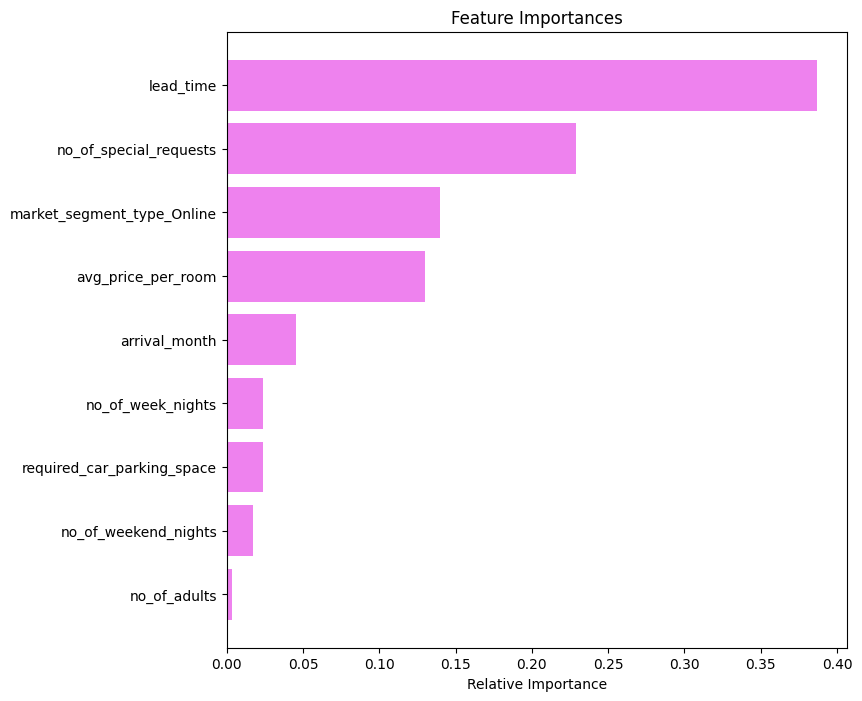

In [54]:
importances = rf_estimator_tuned.feature_importances_

indices = np.argsort(importances)

feature_names = list(X_train.columns)

plt.figure(figsize = (8, 8))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

## **Observations:**

- Like the decision tree model, **Lead Time**, **number of sepcial request, market segement type online, average price per room,** and **arrival month** are the most important features.
- The rest of the variables have very little or no impact in this model, while deciding whether a customer will cancel or not.

## **NAIVE Bayes**

In [55]:
# Naive Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
nb_estimator = GaussianNB()
nb_estimator.fit(X_train, y_train)

GaussianNB()

In [56]:
# evaluating the model performance on the train data
model_train_predictions_nb = nb_estimator.predict(X_train)
model_train_score_nb = f1_score(y_train, model_train_predictions_nb)

print("Model Score on Train Data:", np.round(100*model_train_score_nb, 2))

Model Score on Train Data: 62.85


In [57]:
# evaluating the model performance on the test data
tuned_model_test_predictions_nb = nb_estimator.predict(X_test)
tuned_model_test_score_nb = f1_score(y_test, tuned_model_test_predictions_nb)

print("Model Score on Train Data:", np.round(100*tuned_model_test_score_nb, 2))

Model Score on Train Data: 62.98


## **Observations:**

- The Naive Bayes model seam to perfom much better as the train and the test score are virtually the same (63%)

## **XGBOOST Classifier**

In [58]:
import xgboost as xgb
# Initialize an XGBClassifier with default parameters
XGB_estimator = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGB_estimator.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [59]:
# evaluating the model performance on the train data
model_train_predictions_XGB = XGB_estimator.predict(X_train)
model_train_score_XGB = f1_score(y_train, model_train_predictions_XGB)

print("Model Score on Train Data:", np.round(100*model_train_score_XGB, 2))

Model Score on Train Data: 81.71


In [60]:
# evaluating the model performance on the test data
tuned_model_test_predictions_XGB = XGB_estimator.predict(X_test)
tuned_model_test_score_XGB = f1_score(y_test, tuned_model_test_predictions_XGB)

print("Model Score on Train Data:", np.round(100*tuned_model_test_score_XGB, 2))

Model Score on Train Data: 71.01


## **Observations:**

*  Model score the train data is approximately 82% and that od the test score is 71% indicating the model is overfitting on the train data and requires model tuning.

## **Optimizing the XGBOOST Classifier**

In [61]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize an XGBClassifier with tuned parameters
XGB_estimator_tuned = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',  # 'mlogloss' is typically used for multi-class; use 'logloss' for binary
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.005,
    n_estimators=1000,
    learning_rate=0.02
)


# Fit the classifier to the training data
XGB_estimator_tuned.fit(
    X_train,
    y_train,
    early_stopping_rounds=50,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-logloss:0.59675
[1]	validation_0-logloss:0.59367
[2]	validation_0-logloss:0.58898
[3]	validation_0-logloss:0.58430
[4]	validation_0-logloss:0.57999
[5]	validation_0-logloss:0.57557
[6]	validation_0-logloss:0.57165
[7]	validation_0-logloss:0.56761
[8]	validation_0-logloss:0.56383
[9]	validation_0-logloss:0.56019
[10]	validation_0-logloss:0.55667
[11]	validation_0-logloss:0.55439
[12]	validation_0-logloss:0.55335
[13]	validation_0-logloss:0.55114
[14]	validation_0-logloss:0.54798
[15]	validation_0-logloss:0.54499
[16]	validation_0-logloss:0.54251
[17]	validation_0-logloss:0.54152
[18]	validation_0-logloss:0.53857
[19]	validation_0-logloss:0.53766
[20]	validation_0-logloss:0.53480
[21]	validation_0-logloss:0.53242
[22]	validation_0-logloss:0.52966
[23]	validation_0-logloss:0.52700
[24]	validation_0-logloss:0.52436
[25]	validation_0-logloss:0.52185
[26]	validation_0-logloss:0.51934
[27]	validation_0-logloss:0.51665
[28]	validation_0-logloss:0.51466
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [62]:
# evaluating the model performance on the train data
model_train_predictions_XGB_T = XGB_estimator_tuned.predict(X_train)
model_train_score_XGB_T = f1_score(y_train, model_train_predictions_XGB_T)

print("Model Score on Train Data:", np.round(100*model_train_score_XGB_T, 2))

Model Score on Train Data: 72.82


In [63]:
# evaluating the model performance on the test data
tuned_model_test_predictions_XGB_T = XGB_estimator_tuned.predict(X_test)
tuned_model_test_score_XGB_T = f1_score(y_test, tuned_model_test_predictions_XGB_T)

print("Model Score on Train Data:", np.round(100*tuned_model_test_score_XGB_T, 2))

Model Score on Train Data: 70.0


## **Observations:**

*  The model perfoemnace on the train and test data are very close now after the tuning and can be used for prediction.

## **Feature importance**

In [64]:
print(XGB_estimator.get_booster().get_score(importance_type='weight'))

{'lead_time': 964.0, 'no_of_special_requests': 219.0, 'avg_price_per_room': 983.0, 'no_of_adults': 82.0, 'no_of_weekend_nights': 235.0, 'required_car_parking_space': 34.0, 'no_of_week_nights': 334.0, 'arrival_month': 464.0, 'market_segment_type_Online': 81.0}


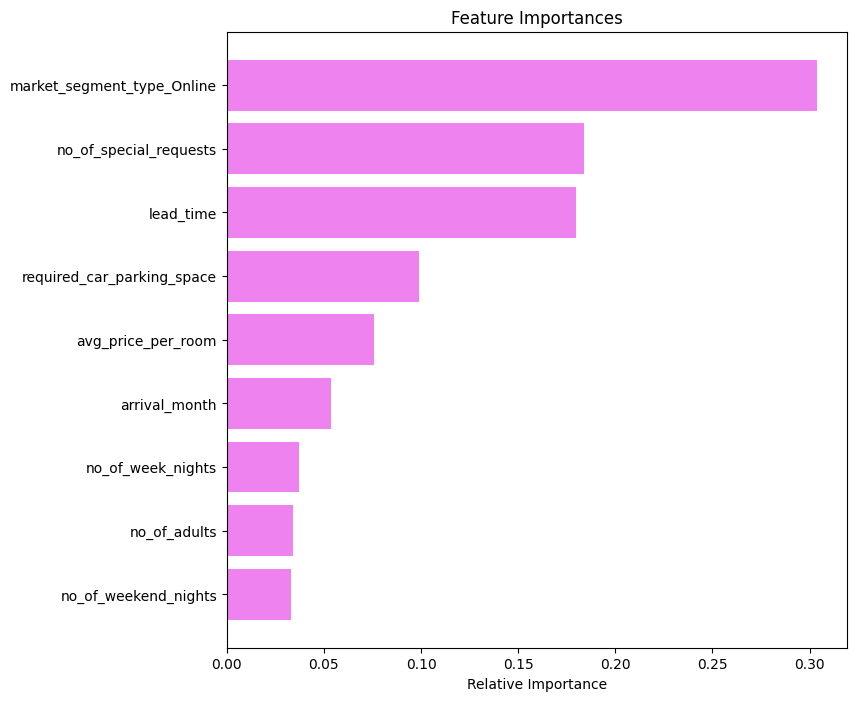

In [65]:
# Assuming XGB_estimator_tuned is your trained model and X_train is your training dataset
importances = XGB_estimator_tuned.feature_importances_
feature_names = X_train.columns

# Combine importances and feature names into a dictionary, then sort them
sorted_feature_importances = sorted(zip(importances, feature_names), reverse=True)

# Unpack the sorted feature importances and names
sorted_importances, sorted_features = zip(*sorted_feature_importances)

# Set up the plot
plt.figure(figsize=(8, 8))
plt.title('Feature Importances')

# Create barh plot
plt.barh(range(len(sorted_importances)), sorted_importances, color='violet', align='center')
plt.yticks(range(len(sorted_features)), sorted_features)

plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


## **Observations:**

- Unlike the decision tree and the random forest, the XGBOOST predicts the market segement type online as the most important feature followed by **number of sepcial requests**, **Lead Time**, **required parking space**, **average price per room,** and **arrival month**.
- The rest of the variables have very little or no impact in this model, while deciding whether a customer will cancel or not.

## **ADABOOST**

In [66]:
from sklearn.ensemble import AdaBoostClassifier
# Initialize the AdaBoostClassifier
ada_estimator = AdaBoostClassifier(n_estimators=100, random_state=0)

# Fit the model to the training data
ada_estimator.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [67]:
# evaluating the model performance on the train data
model_train_predictions_ada = ada_estimator.predict(X_train)
model_train_score_ada = f1_score(y_train, model_train_predictions_ada)

print("Model Score on Train Data:", np.round(100*model_train_score_ada, 2))

Model Score on Train Data: 67.93


In [68]:
# evaluating the model performance on the test data
tuned_model_test_predictions_ada = ada_estimator.predict(X_test)
tuned_model_test_score_ada = f1_score(y_test, tuned_model_test_predictions_ada)

print("Model Score on Train Data:", np.round(100*tuned_model_test_score_ada, 2))

Model Score on Train Data: 66.54


## **Observations:**

*  The model works well on te train data and the test data

## Model Deployment

In [69]:
# exporting the final model to the disk
joblib.dump(final_model, 'hotel_cancellation_prediction_model_v1_0.joblib')

['hotel_cancellation_prediction_model_v1_0.joblib']

In [70]:
# loading the final model from the disk
cancellation_predictor = joblib.load('hotel_cancellation_prediction_model_v1_0.joblib')

In [71]:
# define a function that will take the necessary inputs and make predictions

def predict_cancellation(lead_time, market_segment_type, avg_price_per_room, no_of_adults, no_of_weekend_nights, no_of_week_nights, no_of_special_requests, arrival_month, required_car_parking_space):

    # dictionary of inputs
    input_data = {
        'lead_time': lead_time,
        'no_of_special_requests': no_of_special_requests,
        'avg_price_per_room': avg_price_per_room,
        'no_of_adults': no_of_adults,
        'no_of_weekend_nights': no_of_weekend_nights,
        'required_car_parking_space': 1.0 if required_car_parking_space == "Yes" else 0.0,
        'no_of_week_nights': no_of_week_nights,
        'arrival_month': arrival_month,
        'market_segment_type_Online': 1 if market_segment_type == 'Online' else 0,
    }

    # create a dataframe using the dictionary of inputs
    data_point = pd.DataFrame([input_data])

    # predicting the output and probability of the output
    prediction = cancellation_predictor.predict(data_point).tolist()
    prediction_prob = np.round(100*cancellation_predictor.predict_proba(data_point)[0][0], 2) if prediction == 1 else np.round(100*cancellation_predictor.predict_proba(data_point)[0][1], 2)

    # returning the final output
    return ("Yes", str(prediction_prob)+"%") if prediction[0] == 1 else ("No", str(prediction_prob)+"%")

In [73]:
# creating the deployment input interface
model_inputs = [
    gr.Number(label="Lead Time"),
    gr.Dropdown(label="Market Segment Type", choices=["Online", "Offline"]),
    gr.Number(label="Average Price per Room"),
    gr.Number(label="Number of Adults"),
    gr.Number(label="Number of Weekend Nights"),
    gr.Number(label="Number of Week Nights"),
    gr.Number(label="Number of Special Requests"),
    gr.Dropdown(label="Arrival Month", choices=np.arange(1,13,1).tolist()),
    gr.Dropdown(label="Required Car Parking Space", choices=["Yes", "No"])
]

# creating the deployment output interface
model_outputs = [
    gr.Textbox(label="Will the booking be cancelled?"),
    gr.Textbox(label="Chances of Cancellation")
]

In [74]:
# defining the structure of the deployment interface and how the components will interact
demo = gr.Interface(
    fn = predict_cancellation,
    inputs = model_inputs,
    outputs = model_outputs,
    allow_flagging='never',
    title = "Hotel Booking Cancellation Predictor",
    description = "This interface will predict whether a given hotel booking is likely to be cancelled based on the details of the booking.",
)

In [ ]:
# deploying the model
demo.launch(inline=False, share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d9e79b53b4ed73977b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# shutting down the deployed model
demo.close()